In [104]:
# This is the template for the submission. If you want, you can develop your algorithm in a regular Python script and copy the code here for submission.

# Team members (e-mail, legi):
# zhisun@ethz.ch, 22-958-227
# enjcao@ethz.ch, 22-942-700
# yifzhou@ethz.ch, 22-940-381

In [105]:
%pip install xgboost 

Note: you may need to restart the kernel to use updated packages.


In [116]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from scipy.stats import entropy, kurtosis, skew
from scipy.signal import welch
from scipy.fftpack import fft

from Lilygo.Recording import Recording, data_integrity
from Lilygo.Dataset import Dataset
from scipy import signal

import joblib
import math

import xgboost as xgb
from xgboost import XGBClassifier

from sklearn.decomposition import PCA

import random

## Filtering and Feature Extraction

In [107]:
# data pre-processing
# This function aims to find the component caused by gravity from data, which means the signal around 0 Hz
def get_gravity(data):
    filtered_data = np.zeros_like(data)
    # Parameters in IIR filter
    alpla = [1, -1.979133761292768, 0.979521463540373]
    beta = [0.000086384997973502, 0.00012769995947004, 0.000086384997973502]
    # Formula of IIR filter
    for i in range(2, len(data)):
        filtered_data[i] = alpla[0] * (data[i] * beta[0] + data[i-1] * beta[1] + data[i-2] * beta[2] - filtered_data[i-1] * alpla[1] - filtered_data[i-2] * alpla[2])
    return filtered_data

def get_highpass(data):
    filtered_data = np.zeros_like(data)  # filtered_data
    alpla = [1, -1.905384612118461, 0.910092542787947]
    beta = [0.953986986993339, -1.907503180919730, 0.953986986993339]

    for i in range(2, len(data)):
        filtered_data[i] = alpla[0] * (data[i] * beta[0] + data[i-1] * beta[1] + data[i-2] * beta[2] - filtered_data[i-1] * alpla[1] - filtered_data[i-2] * alpla[2])
    return filtered_data

# This funciton aims to realize a high-pass filter with cutoff frequency = 5 Hz. Because according to massive amounts of data, the general 
# maximum frequency of human walking is about 5 Hz
def get_lowpass(data):
    filtered_data = np.zeros_like(data)  # filtered_data
    alpla = [1, -1.80898117793047, 0.827224480562408]
    beta = [0.096665967120306, -0.172688631608676, 0.095465967120306]

    for i in range(2, len(data)):
        filtered_data[i] = alpla[0] * (data[i] * beta[0] + data[i-1] * beta[1] + data[i-2] * beta[2] - filtered_data[i-1] * alpla[1] - filtered_data[i-2] * alpla[2])
    return filtered_data

def pre_process(data):
    # Find the component caused by gravity from data and remove it from the singanl
    data_gravity = get_gravity(data)
    data_user = data - data_gravity
    # Get user's acceleration along the gravity direction by dot product
    data_acc = data_user * data_gravity
    # Add low pass and high pass filter to reduce noise in signal (possible human walking rate:1 - 5Hz)
    data_filtered = get_highpass(data_acc)
    data_filtered = get_lowpass(data_filtered)
    return data_filtered

def extract_features(trace, window_size=60, sampling_rate=200):
    """
    Preprocess the data and extract features from the 3D accelerometer, gyroscope, and magnetometer data.

    Args:
    trace (Lilygo.Recording.Recording): Object containing the raw data with accelerometer data stored in lists (e.g. trace.data['ax'])
    window_size (int): The window size in seconds for splitting the data
    sampling_rate (int): The sampling rate of the data in Hz

    Returns:
    pd.DataFrame: A DataFrame with the extracted features and location labels
    """
    # Read data from trace
    ax = pre_process(trace.data['ax'].values)
    ay = pre_process(trace.data['ay'].values)
    az = pre_process(trace.data['az'].values)
    
    gx = pre_process(trace.data['gx'].values)
    gy = pre_process(trace.data['gy'].values)
    gz = pre_process(trace.data['gz'].values)
    
    '''mx = trace.data['mx'].values
    my = trace.data['my'].values
    mz = trace.data['mz'].values'''
    
    # Compute the length of each window in samples
    window_samples = window_size * sampling_rate
    
    # Compute the number of windows in the recording
    num_windows = len(ax) // window_samples

    # Initialize lists for storing extracted features and location labels
    features = []
    loc_labels = []

    # Helper function to compute the magnitude of a vector
    magnitude = lambda vec: np.sqrt(np.sum(vec**2, axis=1))

    for i in range(num_windows):
       
        # Extract the accelerometer, gyroscope, and magnetometer data for the current window
        acc_data = np.array([ax[i*window_samples:(i+1)*window_samples],
                             ay[i*window_samples:(i+1)*window_samples],
                             az[i*window_samples:(i+1)*window_samples]]).T
        gyro_data = np.array([gx[i*window_samples:(i+1)*window_samples],
                              gy[i*window_samples:(i+1)*window_samples],
                              gz[i*window_samples:(i+1)*window_samples]]).T
        '''mag_data = np.array([mx[i*window_samples:(i+1)*window_samples],
                             my[i*window_samples:(i+1)*window_samples],
                             mz[i*window_samples:(i+1)*window_samples]]).T'''
        
        '''figure,ax = plt.subplots(3, 1, figsize=(10, 6))
        ax[0].plot(acc_data[:,0])
        ax[0].set_ylabel('ax')
        ax[1].plot(acc_data[:,1])
        ax[1].set_ylabel('ay')
        ax[2].plot(acc_data[:,2])
        ax[2].set_ylabel('az')'''

        # Compute magnitudes
        acc_magnitude = np.sqrt(np.sum(acc_data**2, axis=1))
        acc_mag_mean = abs(np.mean(acc_magnitude))
        acc_mag_std = np.std(acc_magnitude)
        #gyro_magnitude = magnitude(gyro_data)
        #mag_magnitude = magnitude(mag_data)


        # ----ACCELERATOR TIME DOMAIN----
        ax_mean = abs(np.mean(acc_data[:,0]))
        ay_mean = abs(np.mean(acc_data[:,1]))
        az_mean = abs(np.mean(acc_data[:,2]))
        a_mean_list = [ax_mean, ay_mean, az_mean]
        a_mean_list.sort() # Sorting list of numbers in ascending
        Am = a_mean_list[2] # Feature Am: the maximum mean among all dimensions (represents motion range for location)
        Bm = a_mean_list[2]/a_mean_list[1] # Feature Bm and Cm: ratio of the maximum mean in different axes (represents DoF in movement for location)
        Cm = a_mean_list[2]/a_mean_list[0] 

        ax_range = acc_data[np.argmax(acc_data[:,0]), 0] - acc_data[np.argmin(acc_data[:,0]), 0]
        ay_range = acc_data[np.argmax(acc_data[:,1]), 1] - acc_data[np.argmin(acc_data[:,1]), 1]
        az_range = acc_data[np.argmax(acc_data[:,2]), 2] - acc_data[np.argmin(acc_data[:,2]), 2]
        a_range_list = [ax_range, ay_range, az_range]
        a_range_list.sort() # Sorting list of numbers in ascending
        A = a_range_list[2] # Feature A: the maximum range among all dimensions (represents motion range for location)
        B = a_range_list[2]/a_range_list[1] # Feature B and C: ratio of the maximum ranges in different axes (represents DoF in movement for location)
        C = a_range_list[2]/a_range_list[0] 
        
        
        # ----GYROSCOPE TIME DOMAIN----
        gx_mean = abs(np.mean(gyro_data[:,0]))
        gy_mean = abs(np.mean(gyro_data[:,1]))
        gz_mean = abs(np.mean(gyro_data[:,2]))
        g_mean_list = [gx_mean, gy_mean, gz_mean]
        g_mean_list.sort() # Sorting list of numbers in ascending
        Gm = g_mean_list[2] 
        Hm = g_mean_list[2]/g_mean_list[1] 
        Im = g_mean_list[2]/g_mean_list[0] 

        gx_range = gyro_data[np.argmax(gyro_data[:,0]), 0] - gyro_data[np.argmin(gyro_data[:,0]), 0]
        gy_range = gyro_data[np.argmax(gyro_data[:,1]), 1] - gyro_data[np.argmin(gyro_data[:,1]), 1]
        gz_range = gyro_data[np.argmax(gyro_data[:,2]), 2] - gyro_data[np.argmin(gyro_data[:,2]), 2]
        g_range_list = [gx_range, gy_range, gz_range]
        g_range_list.sort() # Sorting list of numbers in ascending
        G = g_range_list[2] 
        H = g_range_list[2]/g_range_list[1] 
        I = g_range_list[2]/g_range_list[0]


        # ----ACCELERATOR FREQUENCY DOMAIN----
        freq, Pxx = welch(acc_magnitude, fs=sampling_rate) # use of the fast Fourier transform for the estimation of power spectra
        freq_band = np.logical_and(freq >= 0.3, freq <= 15) 
        power_in_band = Pxx[freq_band] 
        freq_in_band = freq[freq_band] 
        #plt.plot(freq,Pxx)

        # D and F reflects impact of strides on acceleration
        D = np.max(power_in_band) # Feature D: the maximum energy captured by the accelerator, 
        total_power = np.sum(power_in_band) # Feature F: total power in the frequencies between 0.3 and 15 Hz:

        norm_Pxx = Pxx / total_power # normalize the power spectrum
        E = entropy(norm_Pxx) # Feature E: normalized information entropy of the discrete FFT component magnitudes

        

        sorted_idx = np.argsort(power_in_band)[::-1] 
        first_freq = freq_in_band[sorted_idx[0]] 
        second_freq = freq_in_band[sorted_idx[1]] 
        first_power = power_in_band[sorted_idx[0]] 
        second_power = power_in_band[sorted_idx[1]]

        R1 = np.sum(power_in_band[freq_in_band  < 3]) / total_power
        R3 = np.sum(Pxx[(freq >= 1.5) & (freq <= 2.5)]) / total_power 

        

        # ----MOVING VS: STANDING----
        moving = False
        # Append the features to the list
        # if acc_mag_mean > 0.1 and total_power >0.0001:
        if True:
            moving = True
        
        # Calculate the timestamp for the current window as the median of the timestamps (not necessary for location)
        # timestamp = np.median(trace.timestamp[i*window_samples:(i+1)*window_samples]) 
        try:
            # Determine the location label for the current window based on the timestamp
            loc_label = trace.labels.get('board_loc')
            # Append the label to the labels list
            loc_labels.append(loc_label)
        except Exception as error:
            #print("!-This might be testing trace and does not have labels. Error: ",error)
            pass
        features.append([moving, A, B, C, Am,Bm,Cm, acc_mag_mean , 
                         D, E, total_power, first_freq, first_power,
                         G,H,I,Gm,Hm,Im,acc_mag_std])

    # Create a DataFrame with the extracted features and location labels
    features_df = pd.DataFrame(features, columns=['moving','A', 'B', 'C','Am', 'Bm', 'Cm','acc_mag' ,
                                                  'D', 'E', 'total_power', 'first_freq', 'first_power',
                                                  'G','H','I','Gm','Hm','Im','acc_std'])
    features_df['loc_label'] = loc_labels
    #print(features_df)

    return features_df

In [108]:
# path_training = '/kaggle/input/mobile-health-2023-path-detection/data/train'
path_training = "./data/train/"
traceNames=os.listdir(path_training)

'''# Get features of training traces
X = []
y = []
for traceName in traceNames[3:20]:
    if traceName[-5:] == '.json':
        trace = Recording(path_training+'/'+ traceName, no_labels=False, mute=True)

        figure, ax = plt.subplots(6,1,figsize=(60, 5))
        figure.suptitle(str(trace.labels))
        ax[0].plot(get_lowpass(get_highpass(trace.data['ax'].values)))
        ax[0].plot(get_lowpass(get_highpass(trace.data['ay'].values)))
        ax[0].plot(get_lowpass(get_highpass(trace.data['az'].values)))
        
        
        # Get features of data
        features_df = preprocess_and_extract_features(trace)
        ax[1].plot(features_df['acc_mag'])
        ax[1].fill_between(np.arange(len(features_df['acc_mag'])), 0, 
                           features_df['acc_mag'], 
                           where=features_df['moving']==True, 
                           color='red', alpha=0.3)

        ax[2].plot(features_df['A'])
        ax[2].plot(features_df['B'])
        ax[2].plot(features_df['C'])
        ax[2].legend(['A: Acc-Max_mag','B: Ratio','C: Ratio'])

        ax[3].plot(features_df['D'])
        #ax[3].plot(features_df['E']) # Entropy makes no difference for location
        ax[3].plot(features_df['F'])
        ax[3].legend(['D: Max_energy','F: Overall energy'])

        ax[4].plot(features_df['G'])
        ax[4].plot(features_df['H'])
        ax[4].plot(features_df['I'])
        ax[4].legend(['G: Gyro-Max_mag','B: Ratio','C: Ratio'])

        ax[5].plot(features_df['acc_std'])'''

"# Get features of training traces\nX = []\ny = []\nfor traceName in traceNames[3:20]:\n    if traceName[-5:] == '.json':\n        trace = Recording(path_training+'/'+ traceName, no_labels=False, mute=True)\n\n        figure, ax = plt.subplots(6,1,figsize=(60, 5))\n        figure.suptitle(str(trace.labels))\n        ax[0].plot(get_lowpass(get_highpass(trace.data['ax'].values)))\n        ax[0].plot(get_lowpass(get_highpass(trace.data['ay'].values)))\n        ax[0].plot(get_lowpass(get_highpass(trace.data['az'].values)))\n        \n        \n        # Get features of data\n        features_df = preprocess_and_extract_features(trace)\n        ax[1].plot(features_df['acc_mag'])\n        ax[1].fill_between(np.arange(len(features_df['acc_mag'])), 0, \n                           features_df['acc_mag'], \n                           where=features_df['moving']==True, \n                           color='red', alpha=0.3)\n\n        ax[2].plot(features_df['A'])\n        ax[2].plot(features_df['B']

In [114]:
# add new features
def reshape_to_windows(x, wl, ol):
  """
  Segments signal into windows by reshaping it into 2D
  x: 1-d array to reshape
  wl: no. of samples in window
  ol: no. of samples overlap
  """
  assert wl>ol, 'Window must be longer than overlap'
  step=int(wl-ol)
  nrows = int(1+(x.size-wl)//step)
  n = int(x.strides[0])
  return np.lib.stride_tricks.as_strided(x, shape=(nrows,int(wl)),
                                        strides=(step*n,n))

def get_AC_DC(data, sr, order = 1, crit_freq = 2):
  """
  returns high-pass and low-pass filtered signals using butterworth filter
  data: original windowed signal
  sr = sampling frequency
  order: order of filter
  crit_freq: critical frequency of filter
  """

  sos_low = signal.butter(order, crit_freq, 'lp', fs = sr, output = 'sos')
  sos_high = signal.butter(order, crit_freq, 'hp', fs = sr, output = 'sos')
  AC = signal.sosfilt(sos_low, data)
  DC = signal.sosfilt(sos_high, data)
  return AC, DC


def extract_temporal_features(data):
  """
  returns time domain features (20) from windowed raw signal:
   - mean, standard deviation, kurtosis, skewness;
   - RMS, zero-crossing
   - The following percentiles: [0, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 95, 100] (Q)
   - Range: max(x) - min(x)
  data: windowed signal
  """
  m = np.mean(data)
  sd = np.std(data)
  kurt = kurtosis(data)
  sk = skew(data)
  rms = np.sqrt(np.mean(data**2))
  zc = np.sum(np.diff(data>=m))
  q = np.array([0, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 1])
  Q = np.quantile(data, q)
  range = Q[-1]-Q[0]             
  return m, sd, kurt, sk, rms, zc, range, Q[0], Q[1], Q[2], Q[3], Q[4], Q[5], Q[6], Q[7], Q[8], Q[9], Q[10], Q[11], Q[12]


def extract_frequential_features(data, sr):
  """
  exctracting frequncy domain features (5) from windowed Fourier transform:
   - energy, entropy, centroid, bandwidth, max_freq
  data: windowed signal
  sf: sampling rate
  """
  window_size = len(data)
  data -= np.mean(data)
  ft = np.fft.fft(data)/window_size
  sr = int(sr)
  # get window length
  
  #discarding mirror part
  ft = ft[:window_size//2]
  #frequencies of the transform
  freqs = np.fft.fftfreq(window_size, 1/sr)[1:window_size//2]
  #the spectral density is the squared of the absolute
  Spec = np.abs(ft)**2
  #Energy
  E = np.sum(Spec)/(window_size//2)
  #density
  P = Spec[1:]/np.sum(Spec[1:])
  #entropy
  H = -np.sum(P*np.log2(P))/np.log2((window_size//2))
  #centriod 
  C = np.sum(P.T*freqs)

  #Absolute distance  of frequencies from from Centroid
  distC = np.abs((C-freqs))
  #bandwidth is the weighted mean of the distance
  BW = np.sum(distC*P)
  #maximum frequency 
  max_fr = freqs[np.argmax(Spec[1:])]
  return E, H, C, BW, max_fr

# 25 features
def get_features(data):
  # AC, DC = get_AC_DC(data, 200)
  m, sd, kurt, sk, rms, zc, range, q_0, q_1, q_2, q_3, q_4, q_5, q_6, q_7, q_8, q_9, q_10, q_11, q_12 = extract_temporal_features(data)
  E, H, C, BW, max_fr = extract_frequential_features(data, 200)
  all_features = [m, sd, kurt, sk, rms, zc, range, q_0, q_1, q_2, q_3, q_4, q_5, q_6, q_7, q_8, q_9, q_10, q_11, q_12, E, H, C, BW, max_fr]
  return all_features

## Load training traces and train

features from szc


In [150]:
dir_data = '.\\data\\'
path_training = dir_data + 'train\\'
traceNames=os.listdir(path_training)

# Get features of training traces
X = pd.DataFrame()
y = pd.DataFrame()
for traceName in traceNames[0:10]:
    if traceName[-5:] == '.json':
        trace = Recording(path_training+'/'+ traceName, no_labels=False, mute=True)

        ax = pre_process(trace.data['ax'].values)
        ay = pre_process(trace.data['ay'].values)
        az = pre_process(trace.data['az'].values)
        acc_data = np.array([ax,ay,az]).T
        acc_magnitude = np.sqrt(np.sum(acc_data**2, axis=1))

        loc_label= pd.DataFrame([trace.labels.get('board_loc')])
        acc_mag_win=reshape_to_windows(acc_magnitude, wl=2000, ol=0) #shape:(n_window, window_size)
        n_window = acc_mag_win.shape[0]
        for i in range(n_window):
            windowed_data = acc_mag_win[i,:]
            features = pd.DataFrame(get_features(windowed_data))
            # Prepare data for classification
            X = pd.concat([X, features], axis=1).reset_index(drop=True)
            y = pd.concat([y, loc_label], axis=1).reset_index(drop=True)
        
# Normalize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Using features of all training traces as training set
Xs_train = X_scaled.T
ys_train = y.T
print(Xs_train.shape,ys_train.shape)

(479, 25) (479, 1)


get features of zyf

In [143]:
# path_training = '/kaggle/input/mobile-health-2023-path-detection/data/train'
# path_training = "./data/train/"
# dir_data = 'E:\\Sunzhichao\\ETHz\\2223Spring\\Mobile_Health\\data\\'
dir_data = '.\\data\\'
path_training = dir_data + 'train\\'
traceNames=os.listdir(path_training)

# Get features of training traces
X = pd.DataFrame()
y = pd.DataFrame()
for traceName in traceNames[0:10]:
    if traceName[-5:] == '.json':
        trace = Recording(path_training+'/'+ traceName, no_labels=False, mute=True)

        features_df = extract_features(trace)
        features_df = features_df[features_df['moving']] # Keep only moving windows
        
        # Prepare data for classification
        X_trace = features_df.drop(['loc_label'], axis=1)
        y_trace = features_df['loc_label']
        X = pd.concat([X, X_trace], axis=0).reset_index(drop=True)
        y = pd.concat([y, y_trace], axis=0).reset_index(drop=True)
        
# Normalize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Using features of all training traces as training set
Xs_train = X_scaled
ys_train = y
print(Xs_train.shape,ys_train.shape)

# Using features of all training traces as training set
# X_train = X_scaled
# y_train = y
# X_train, _, y_train, _ = train_test_split(X_scaled, y, test_size=0.01, random_state=42)

# Check the number of classes in y_train
'''if len(set(y_train)) < 2:
    raise ValueError("The number of classes has to be greater than one; got %d class" % len(set(y_train)))'''
  
# Perform PCA on the features
# pca = PCA(n_components=8) # specify the number of principal components to keep
# X_pca = pca.fit_transform(X_scaled)
# print('Principal Components: ', pca.components_)
# print('Explained variance ratio:', pca.explained_variance_ratio_)

# Plot the cumulative explained variance ratio
"""plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.show()"""



KeyboardInterrupt: 

In [151]:


X_train, X_test, y_train, y_test = train_test_split(Xs_train, ys_train, test_size = 0.1, shuffle = False)

# Create the XGBoost DMatrix object
dtrain = xgb.DMatrix(X_train, label=y_train)

# Set the parameters for the XGBoost model
params = {'eta': 0.3, 'gamma': 0,  'max_depth': 7, 'max_delta_step':5, 'num_class': 3, }

# Train the model
xgb_model = xgb.train(params, dtrain)
print("Training XGBoost classifier for location")

# Create the XGBoost DMatrix object for the test data
dtest = xgb.DMatrix(X_test)
y_pred = xgb_model.predict(dtest)

print("accuracy: ", accuracy_score(y_test, y_pred))

# Save the trained xgboost model
joblib.dump(xgb_model, './trained_models/location_xgboost_model.joblib')

Training XGBoost classifier for location
accuracy:  0.8333333333333334


['./trained_models/location_xgboost_model.joblib']

### Train XGBoost with determined hyperparameters

In [39]:
X_train, X_test, y_train, y_test = train_test_split(Xs_train, ys_train, test_size = 0.3, shuffle = True)

# Create the XGBoost DMatrix object
dtrain = xgb.DMatrix(X_train, label=y_train)

# Set the parameters for the XGBoost model
params = {'eta': 0.3,  'max_depth': 5, 'num_class': 3, 'objective': 'multi:softmax'}

# Train the model
xgb_model = xgb.train(params, dtrain)
print("Training XGBoost classifier for activity")

# Create the XGBoost DMatrix object for the test data
dtest = xgb.DMatrix(X_test)
y_pred = xgb_model.predict(dtest)

print("accuracy: ", accuracy_score(y_test, y_pred))

# Save the trained xgboost model
joblib.dump(xgb_model, './trained_models/location_xgboost_model.joblib')


ValueError: With n_samples=1, test_size=0.3 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.

### Train SVM

In [ ]:
# Train the SVM classifier with RBF kernel
param_grid = {'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001]}
grid = GridSearchCV(SVC(kernel='rbf'), param_grid, refit=True, verbose=2)
grid.fit(X_train, np.ravel(y_train))

# Print the best hyperparameters and the corresponding accuracy score
print("Best Hyperparameters: ", grid.best_params_)
print("Best Accuracy Score: ", grid.best_score_)

# Save the trained SVM model
joblib.dump(grid.best_estimator_, './trained_models/location_svm_model.joblib')#
# joblib.dump(grid, './trained_models/location_svm_model.joblib')

In [55]:
model = 'xgBoost'

if model == 'SVM':
    # Train the SVM classifier with RBF kernel
    param_grid = {
        'C': [0.1, 1, 10, 100], 
        'gamma': [1, 0.1, 0.01, 0.001]
        }
    grid = GridSearchCV(SVC(kernel='rbf'), param_grid, refit=True, verbose=2)
    grid.fit(X_train, np.ravel(y_train))
    
    # Save the trained SVM model
    joblib.dump(grid.best_estimator_, './trained_models/location_svm_model.joblib')#
    # joblib.dump(grid, './trained_models/location_svm_model.joblib')
    
elif model == 'xgBoost':
    # Define the XGBoost DMatrix object
    dtrain = xgb.DMatrix(X_train, label=y_train)

    # Define the hyperparameters to be tuned
    params = {
        'max_depth': [3, 5, 7],
        'learning_rate': [0.1, 0.05, 0.01],
        'eta': [0.3, 0.2, 0.1, 0.05, 0.01],
        'n_estimators': [50, 100, 500, 1000],
        'objective': ['multi:softmax'],
        'num_class': [3], #Best Hyperparameters:  {'eta': 0.3, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 1000, 'num_class': 3, 'objective': 'multi:softmax'} Best Accuracy Score:  0.916336131918875
    }
    '''params = {
        'max_depth': [3, 7],
        'learning_rate': [0.1, 0.01],
        'eta': [ 0.2, 0.1],
        'n_estimators': [50, 100],
        'objective': ['multi:softmax'],
        'num_class': [3],
    } ''' #Best Hyperparameters:  {'eta': 0.2, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 100, 'num_class': 3, 'objective': 'multi:softmax'} Best Accuracy Score:  0.9072221049713012

    # Define the XGBoost classifier
    xgb_classifier = xgb.XGBClassifier()

    # Define the GridSearchCV object
    grid = GridSearchCV(estimator = xgb_classifier, param_grid = params, cv=5, n_jobs=-1, scoring='accuracy')

    # Fit the GridSearchCV object to the training data
    grid.fit(X_train, y_train)

    
    # Save the trained xgboost model
    joblib.dump(grid, './trained_models/location_xgboost_model.joblib')


# Print the best hyperparameters and the corresponding accuracy score
print("Best Hyperparameters: ", grid.best_params_)
print("Best Accuracy Score: ", grid.best_score_)

Best Hyperparameters:  {'eta': 0.3, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 1000, 'num_class': 3, 'objective': 'multi:softmax'}
Best Accuracy Score:  0.916336131918875


## Predict on testing traces with trained model and Evaluation predictions

with new features from szc

Prediction for every window:  [0. 0. 2. 2. 2. 0. 0. 2. 2. 2. 0. 0. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 2. 2. 0. 0. 2. 2. 0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 2. 2.
 2. 2. 2. 2. 2. 0. 0.]
Overall prediction fot the whole trace: 0
(figure below, if pred wrong) label: 2 prediction: 0


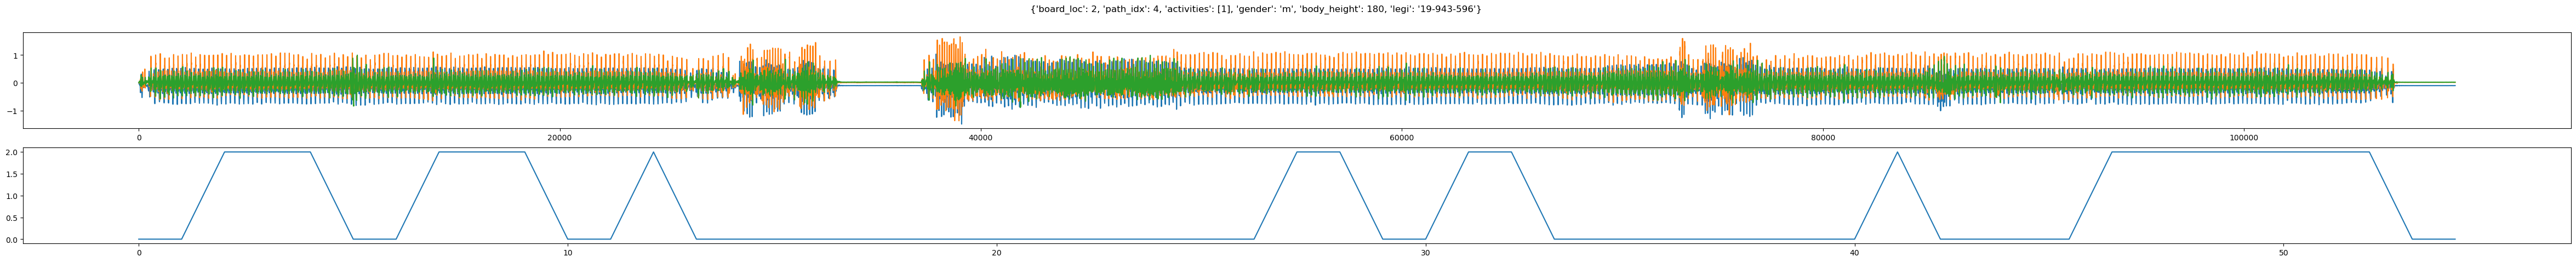

Prediction for every window:  [0. 0. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 2. 2. 2.
 2. 0. 0. 0. 0. 0. 0.]
Overall prediction fot the whole trace: 0
(figure below, if pred wrong) label: 2 prediction: 0


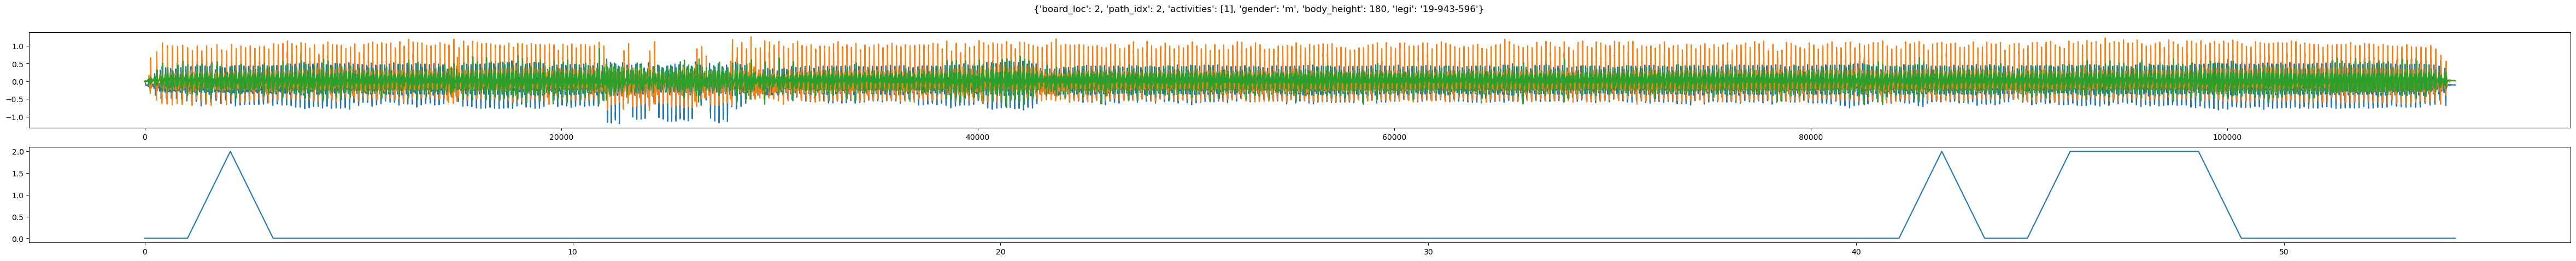

Prediction for every window:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 2.]
Overall prediction fot the whole trace: 0
(figure below, if pred wrong) label: 2 prediction: 0


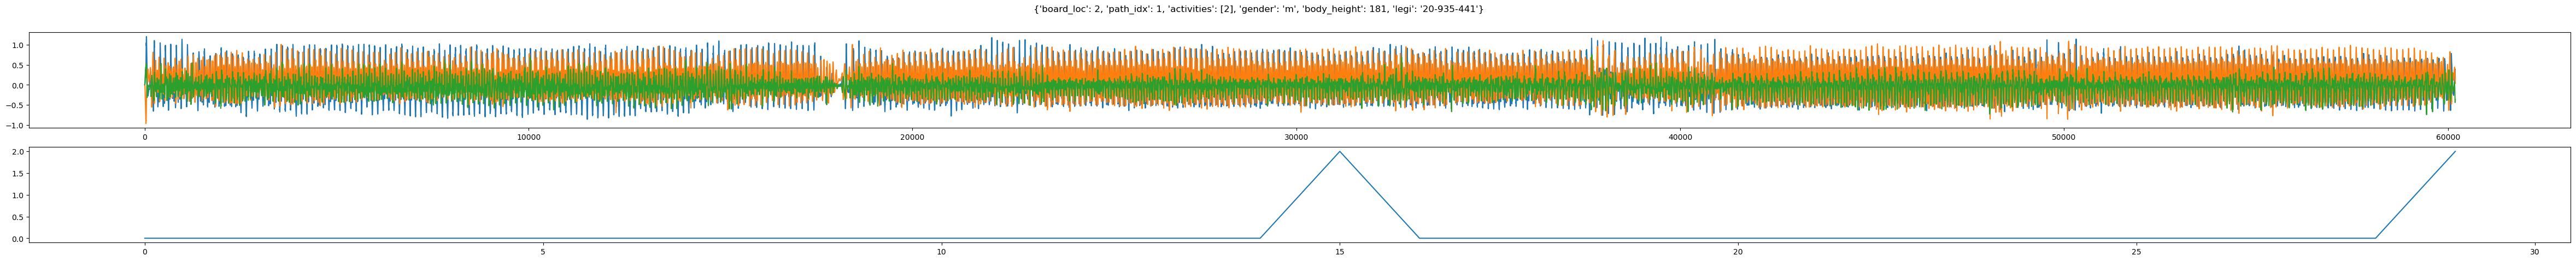

Prediction for every window:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 0.
 0. 0. 0. 2. 0. 0. 2. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Overall prediction fot the whole trace: 0
(figure below, if pred wrong) label: 2 prediction: 0


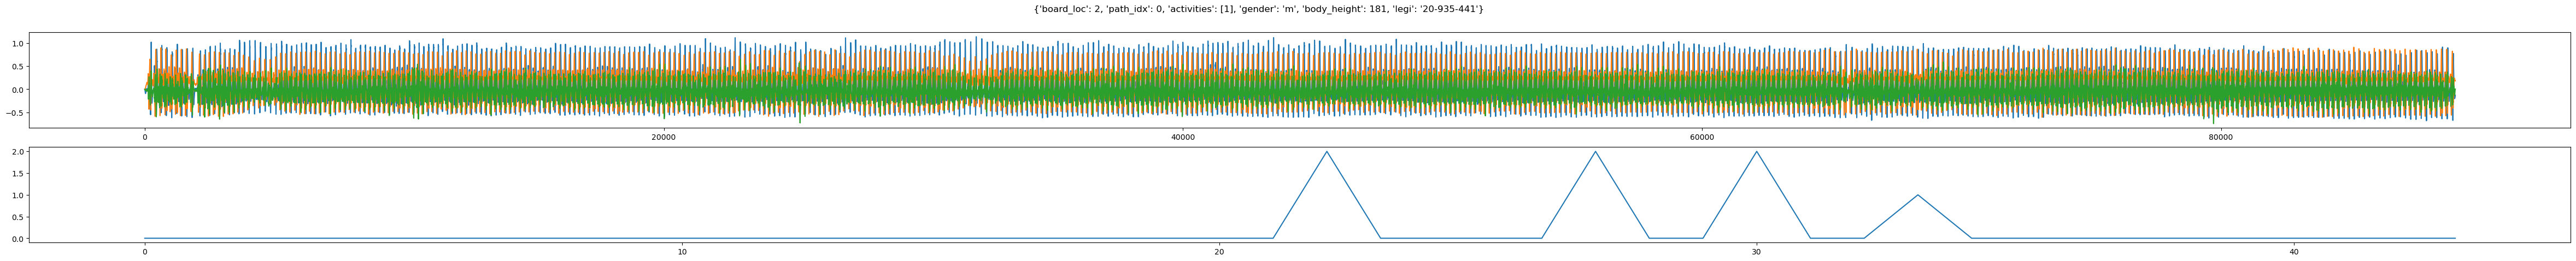

Prediction for every window:  [0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 2. 2. 0. 2. 0. 0. 2. 0. 0. 2. 0. 2. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 0.]
Overall prediction fot the whole trace: 0
(figure below, if pred wrong) label: 1 prediction: 0


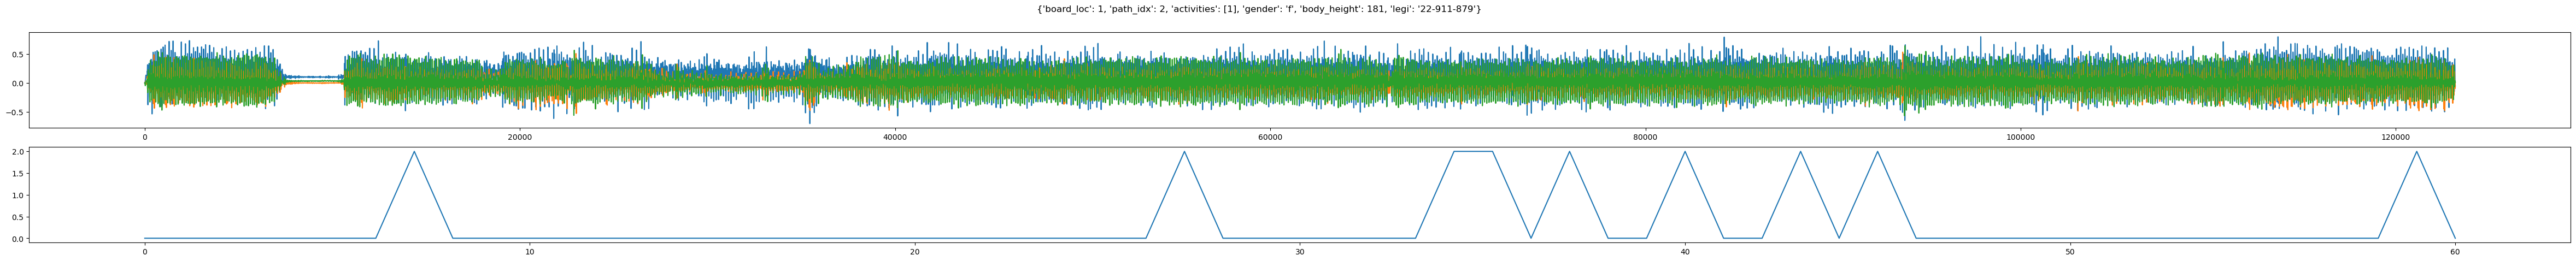

Prediction for every window:  [0. 0. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2.]
Overall prediction fot the whole trace: 0
(figure below, if pred wrong) label: 0 prediction: 0
Prediction for every window:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 2. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
Overall prediction fot the whole trace: 0
(figure below, if pred wrong) label: 0 prediction: 0
Prediction for every window:  [0. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 2. 0. 0. 2. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Overall prediction fot the whole trace: 0
(figure below, if pred wrong) label: 0 prediction: 0
Prediction for every window:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

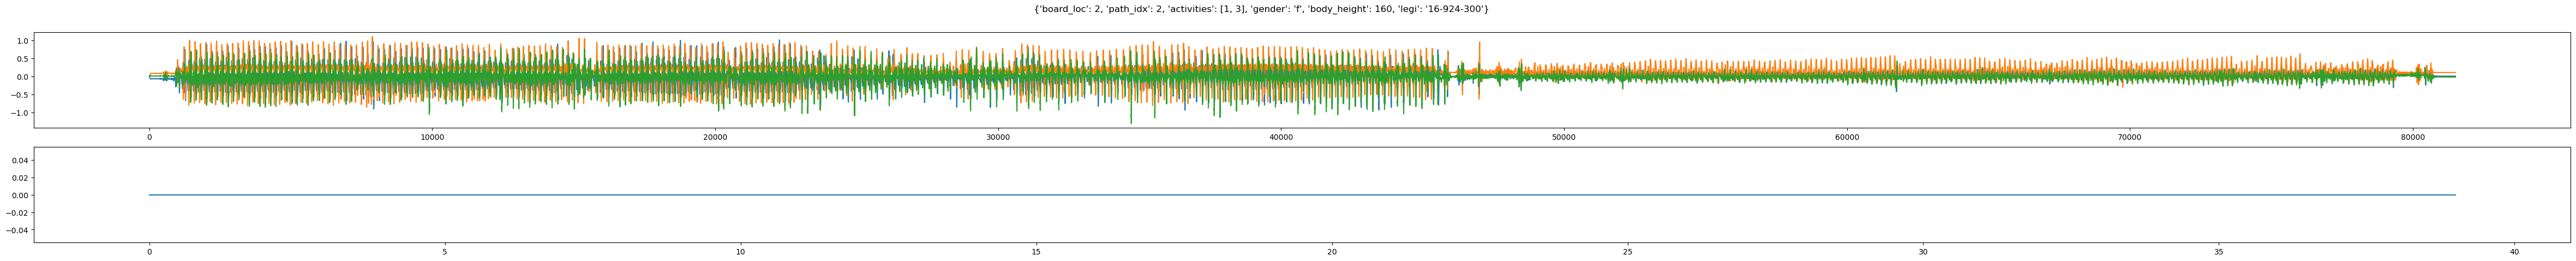

Confusion Matrix:
 [[0 0]
 [1 0]]
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       0.0
           2       0.00      0.00      0.00       1.0

    accuracy                           0.00       1.0
   macro avg       0.00      0.00      0.00       1.0
weighted avg       0.00      0.00      0.00       1.0

Accuracy Score: 0.0


e:\Anaconda3\envs\mhealth23\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
e:\Anaconda3\envs\mhealth23\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
e:\Anaconda3\envs\mhealth23\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
e:\Anaconda3\envs\mhealth23\lib\site-packages\sklearn\

In [153]:
plot_wrong_prediton = True
loaded_model = joblib.load('./trained_models/location_xgboost_model.joblib')


y_labels = [] # labels of all testing traces
y_overalls = [] # final overall predictions for all testing traces

for traceName in traceNames[0:10]:
    if traceName[-5:] == '.json':
        # Load trace and extract features
        trace = Recording(path_training+'/'+ traceName, no_labels=False, mute=True)

        ax = pre_process(trace.data['ax'].values)
        ay = pre_process(trace.data['ay'].values)
        az = pre_process(trace.data['az'].values)
        acc_data = np.array([ax,ay,az]).T
        acc_magnitude = np.sqrt(np.sum(acc_data**2, axis=1))

        y_label= trace.labels.get('board_loc')
       
        acc_mag_win=reshape_to_windows(acc_magnitude, wl=2000, ol=0) #shape:(n_window, window_size)
        n_window = acc_mag_win.shape[0]
        features=np.zeros((n_window,25))
        
        for i in range(n_window):
            windowed_data = acc_mag_win[i,:]
            windowed_features = pd.DataFrame(get_features(windowed_data))
            #print(windowed_features.shape)
            features[i,:]=np.squeeze(windowed_features)
        
        # Normalize the features
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(features)
        dtest = xgb.DMatrix(X_scaled) # Create the XGBoost DMatrix object for the test data
    
        # Predict the location with loaded model
        y_pred = loaded_model.predict(dtest)
        y_pred = np.squeeze(y_pred)
        print('Prediction for every window: ',y_pred)
        y_overall = np.argmax(np.bincount(y_pred.astype(int))) # Get the mode of predictions of every windows in a trace of the final overall predicition for the whole trace
        print('Overall prediction fot the whole trace:',y_overall)
        
        print('(figure below, if pred wrong) label:',y_label,'prediction:',y_overall)
        
        if y_overall != y_label and plot_wrong_prediton:
            figure, ax = plt.subplots(2,1,figsize=(60, 5))
            figure.suptitle(str(trace.labels))
            ax[0].plot(get_lowpass(get_highpass(trace.data['ax'].values)))
            ax[0].plot(get_lowpass(get_highpass(trace.data['ay'].values)))
            ax[0].plot(get_lowpass(get_highpass(trace.data['az'].values)))

            """ax[1].plot(features_df['acc_mag'])
        
            ax[2].plot(features_df['A'])
            ax[2].plot(features_df['B'])
            ax[2].plot(features_df['C'])
            ax[2].legend(['A: Acc-Max_mag','B: Ratio','C: Ratio'])"""

            ax[1].plot(y_pred)
            plt.show()
        
y_labels.append(y_label)
y_overalls.append(y_overall)
# Convert list to array    
y_labels = np.array(y_labels)
y_overalls = np.array(y_overalls)

# Evaluate the classifier
print("Confusion Matrix:\n", confusion_matrix(y_labels, y_overalls))
print("Classification Report:\n", classification_report(y_labels, y_overalls))
print("Accuracy Score:", accuracy_score(y_labels, y_overalls))

with old features

(figure below, if pred wrong) label: 2 prediction: 2
(figure below, if pred wrong) label: 2 prediction: 0


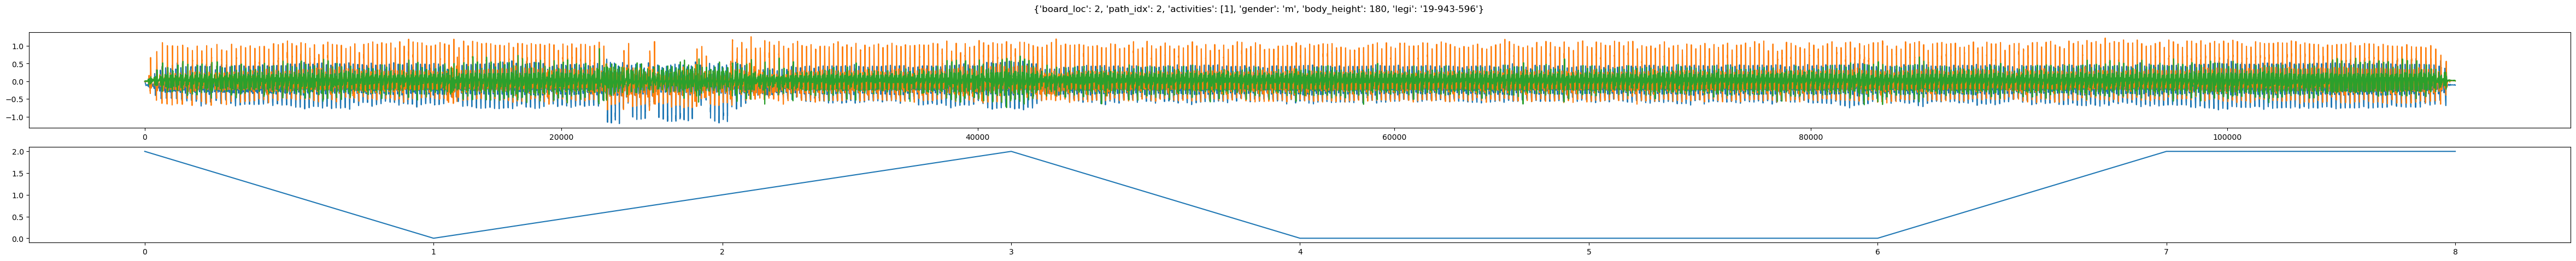

(figure below, if pred wrong) label: 2 prediction: 0


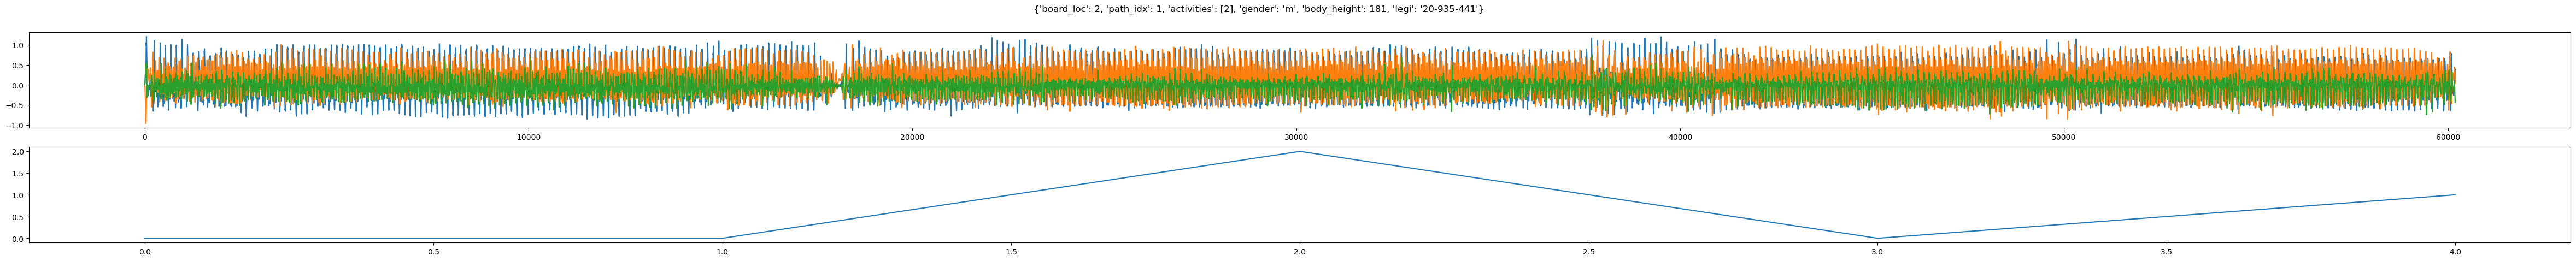

(figure below, if pred wrong) label: 2 prediction: 0


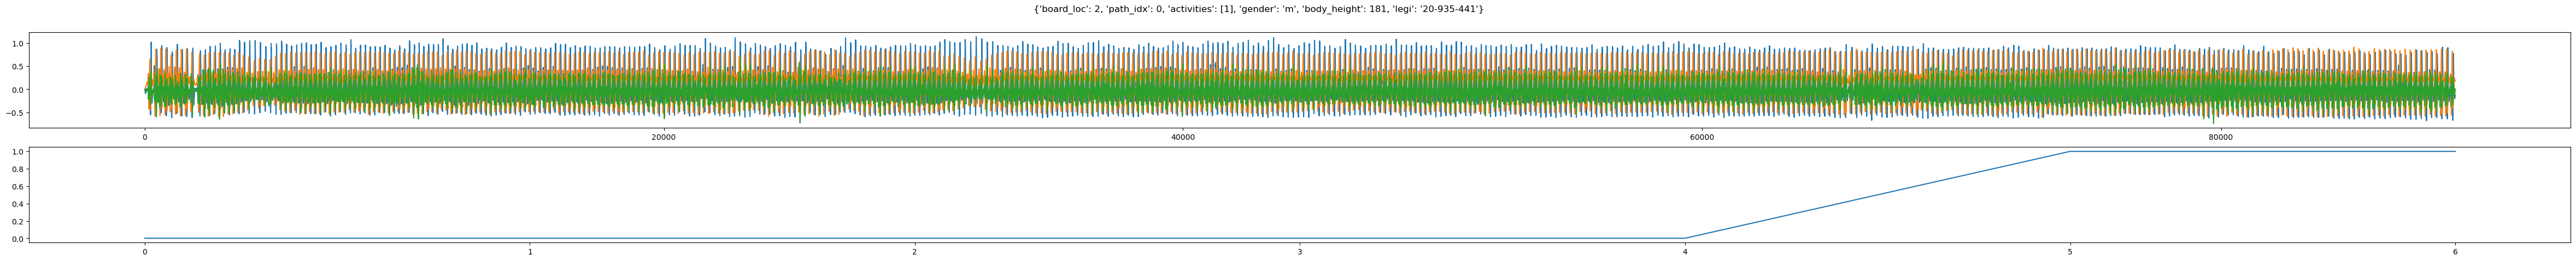

(figure below, if pred wrong) label: 1 prediction: 0


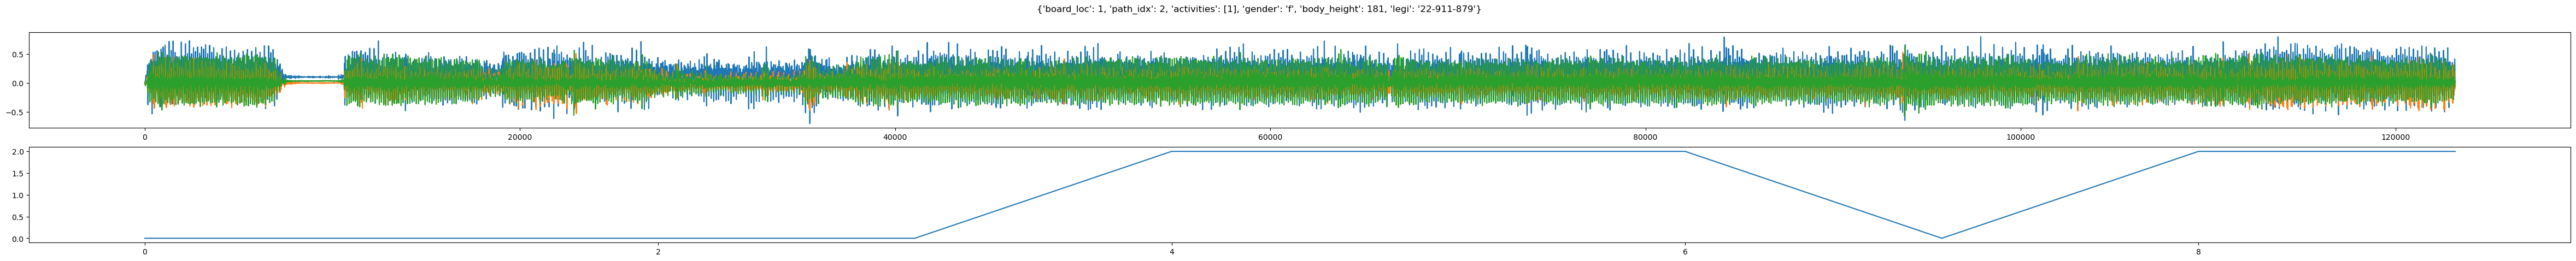

(figure below, if pred wrong) label: 0 prediction: 2


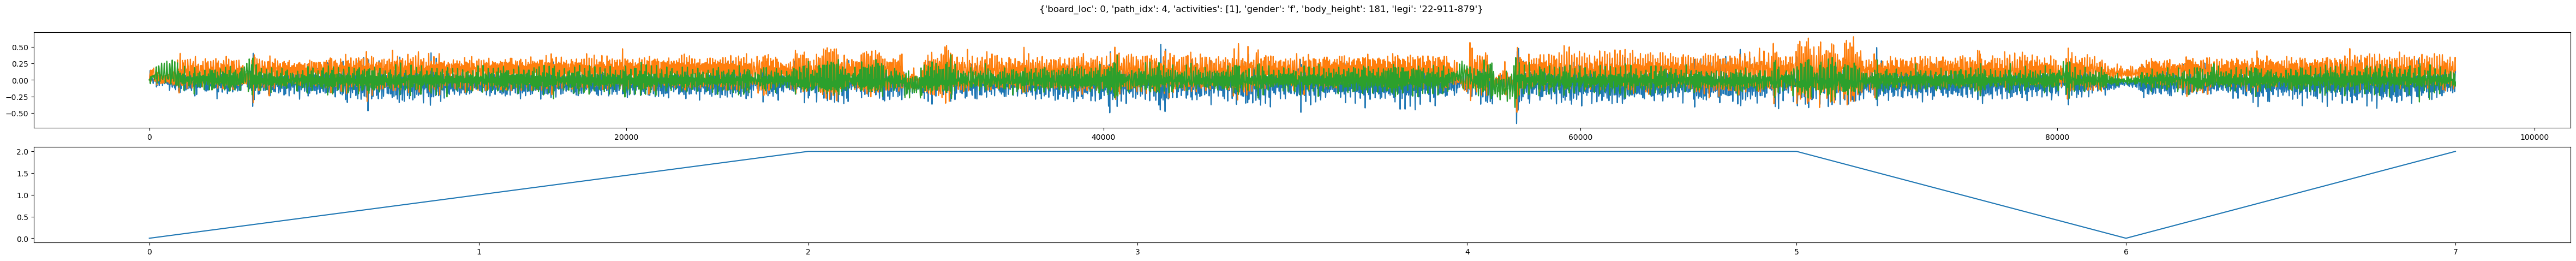

(figure below, if pred wrong) label: 0 prediction: 2


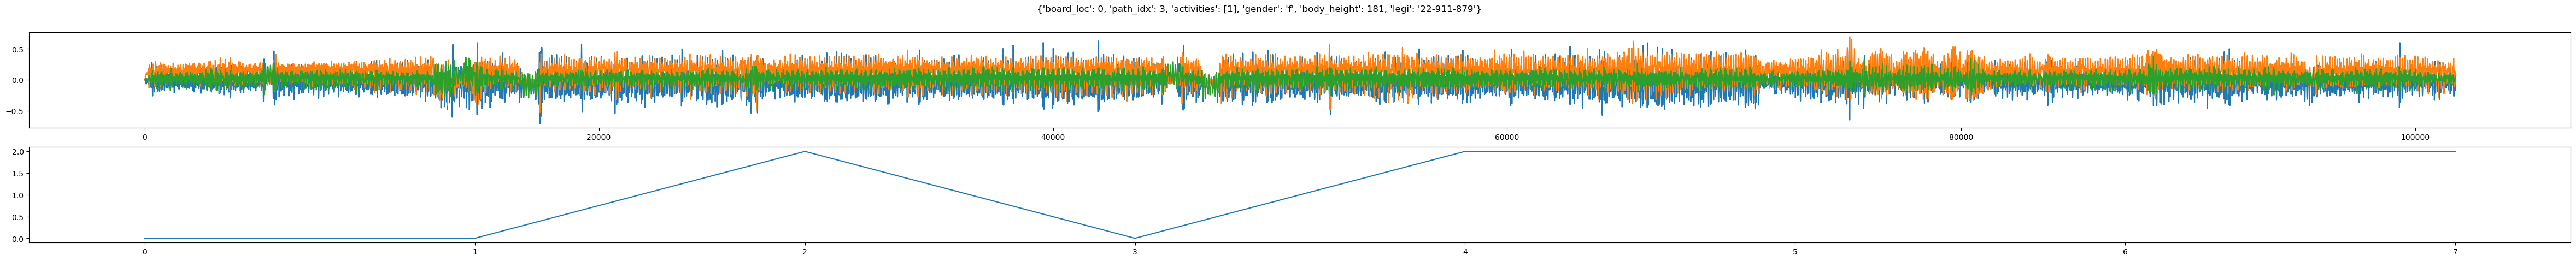

(figure below, if pred wrong) label: 0 prediction: 2


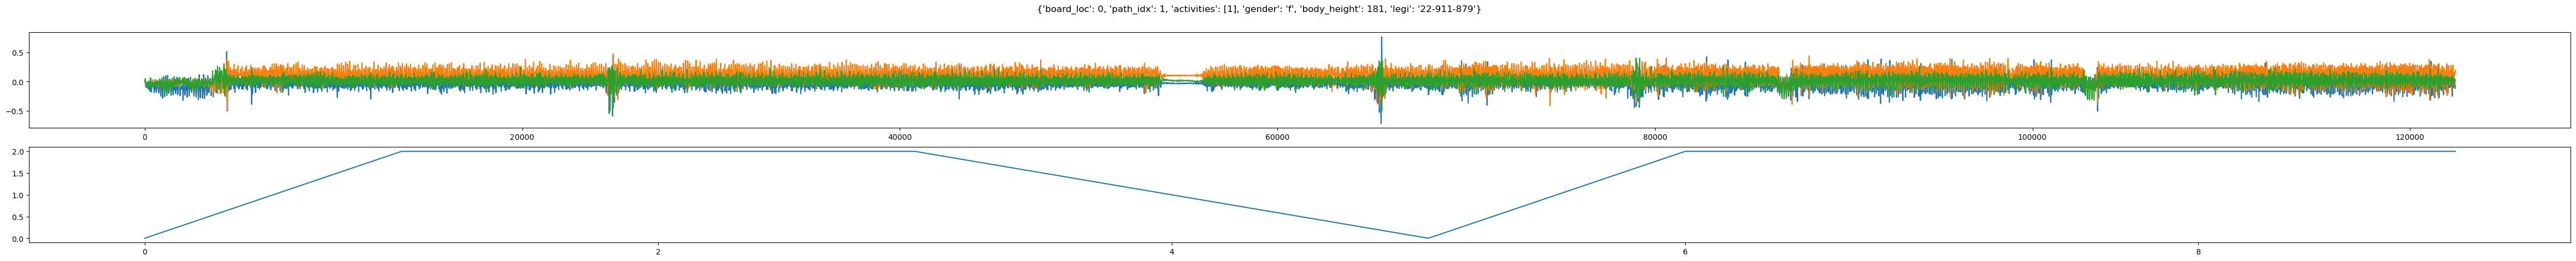

(figure below, if pred wrong) label: 0 prediction: 0
(figure below, if pred wrong) label: 2 prediction: 2
Confusion Matrix:
 [[1 0 3]
 [1 0 0]
 [3 0 2]]
Classification Report:
               precision    recall  f1-score   support

           0       0.20      0.25      0.22         4
           1       0.00      0.00      0.00         1
           2       0.40      0.40      0.40         5

    accuracy                           0.30        10
   macro avg       0.20      0.22      0.21        10
weighted avg       0.28      0.30      0.29        10

Accuracy Score: 0.3


e:\Anaconda3\envs\mhealth23\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
e:\Anaconda3\envs\mhealth23\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
e:\Anaconda3\envs\mhealth23\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [95]:

plot_wrong_prediton = True
model = 'xgBoost'

if model == 'SVM':
    loaded_model = joblib.load('./trained_models/location_svm_model.joblib')
elif model == 'xgBoost':
    loaded_model = joblib.load('./trained_models/location_xgboost_model.joblib')



y_labels = [] # labels of all testing traces
y_overalls = [] # final overall predictions for all testing traces

for traceName in traceNames[0:10]:
    if traceName[-5:] == '.json':
        # Load trace and extract features
        trace = Recording(path_training+'/'+ traceName, no_labels=False, mute=True)
        features_df = extract_features(trace)
        features_df = features_df[features_df['moving']] # Keep only moving windows
    
        # Prepare data for classification
        y_trace = features_df['loc_label'] # loc labels for every window in a trace (the same loc for one trace)
        y_label = np.argmax(np.bincount(y_trace.astype(int))) # Squeeze the same loc labels for every window of a trace into the only label for the whole trace
        y_labels.append(y_label)

        X_test = features_df.drop(['loc_label'], axis=1)
        assert all(X_test['moving']), "Not all features are extracted from moving part"
        X_test_scaled = scaler.fit_transform(X_test)
    
        #X_test_pca = pca.fit_transform(X_test_scaled)
        if model == 'xgBoost':
            dtest = xgb.DMatrix(X_test_scaled) # Create the XGBoost DMatrix object for the test data
        
        # Predict the location with loaded model
        y_pred = loaded_model.predict(dtest)
        y_pred = np.squeeze(y_pred)
        y_overall = np.argmax(np.bincount(y_pred.astype(int))) # Get the mode of predictions of every windows in a trace of the final overall predicition for the whole trace
        y_overalls.append(y_overall)
        print('(figure below, if pred wrong) label:',y_label,'prediction:',y_overall)
        
        if y_overall != y_label and plot_wrong_prediton:
            figure, ax = plt.subplots(2,1,figsize=(60, 5))
            figure.suptitle(str(trace.labels))
            ax[0].plot(get_lowpass(get_highpass(trace.data['ax'].values)))
            ax[0].plot(get_lowpass(get_highpass(trace.data['ay'].values)))
            ax[0].plot(get_lowpass(get_highpass(trace.data['az'].values)))

            """ax[1].plot(features_df['acc_mag'])
        
            ax[2].plot(features_df['A'])
            ax[2].plot(features_df['B'])
            ax[2].plot(features_df['C'])
            ax[2].legend(['A: Acc-Max_mag','B: Ratio','C: Ratio'])"""

            ax[1].plot(y_pred)
            plt.show()
        

# Convert list to array    
y_labels = np.array(y_labels)
y_overalls = np.array(y_overalls)

# Evaluate the classifier
print("Confusion Matrix:\n", confusion_matrix(y_labels, y_overalls))
print("Classification Report:\n", classification_report(y_labels, y_overalls))
print("Accuracy Score:", accuracy_score(y_labels, y_overalls))
        